In [1]:
import sys
sys.path.insert(0, '../')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fsize = 18
params = {'legend.fontsize': fsize*0.925,          
          'axes.labelsize': fsize*1.2,
          'axes.titlesize':fsize*1.5,
          'xtick.labelsize':fsize,
          'ytick.labelsize':fsize,
          'savefig.dpi': 1000}
sns.set(palette='pastel', rc=params)


import os
import numpy as np
import scipy.io as sio

import seaborn as sns

from utils import io_utils
from analysis import analysis_funcs as af
from analysis import stats
from analysis import exp_filepaths
import pandas as pd
pd.set_option('display.max_colwidth', 50)
pd.options.display.float_format = '{:,.4f}'.format

/home/arjundd/anaconda3/envs/tf_36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
cv1_base_path = '/bmrNAS/people/arjun/msk_seg_networks/control_exps/unet_2d/2019-03-10-10-45-24/cv-exp-%03d/test_results'
cv2_base_path = '/bmrNAS/people/arjun/msk_seg_networks/control_exps/unet_2d/2019-03-11-00-31-04/cv-exp-%03d/test_results'
holdout_path = exp_filepaths.BASELINE_UNET

In [3]:
def load_cv_metrics(cv_base_path):
    ds = [io_utils.load_pik(os.path.join(cv_base_path % i, 'metrics.dat')) for i in range(1,7)]
    cv_metrics = {}
    for k in ds[0].keys():
        cv_metrics[k] = []
        for d in ds:
            cv_metrics[k].extend(d[k])
    return cv_metrics

In [4]:
# load data
holdout_metrics = io_utils.load_pik(os.path.join(holdout_path, 'metrics.dat'))
cv1_metrics = load_cv_metrics(cv1_base_path)
cv2_metrics = load_cv_metrics(cv2_base_path)
cv_exps = {'cv1 (k=6)': cv1_metrics, 'cv2 (k=6)': cv2_metrics, 'holdout': holdout_metrics}
ordered_keys = ['holdout', 'cv1 (k=6)', 'cv2 (k=6)']

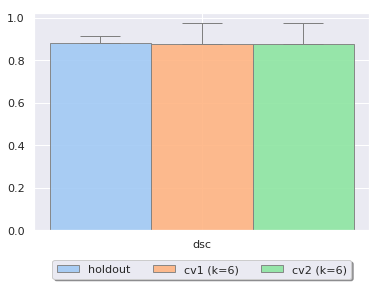

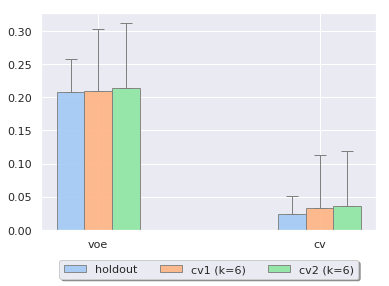

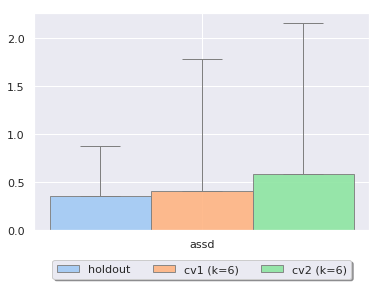

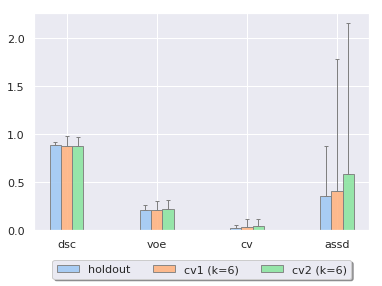

,holdout,cv1 (k=6),cv2 (k=6)
dsc,$0.883\pm0.033$,$0.8783\pm0.097$,$0.8747\pm0.099$
voe,$0.208\pm0.05$,$0.209\pm0.094$,$0.2142\pm0.098$
cv,$0.0244\pm0.027$,$0.0331\pm0.08$,$0.0366\pm0.082$
assd,$0.3544\pm0.518$,$0.4071\pm1.372$,$0.5836\pm1.575$


In [7]:
# plot validation losses
def plot_metrics(metrics, ordered_keys, cv_exps):
    count = 0
    t_mean = []
    t_error = []

    for m in metrics:
        m_mean = []
        m_error = []
        for k in ordered_keys:
            exp_metrics = cv_exps[k]
            data = exp_metrics[m]

            m_mean.append(np.mean(data))
            m_error.append(np.std(data))

        t_mean.append(m_mean)
        t_error.append(m_error)

    exp_means = pd.DataFrame(t_mean, index=metrics, columns=ordered_keys)
    exp_stds = pd.DataFrame(t_error, index=metrics, columns=ordered_keys)
    
    af.display_bar_graph(exp_means, exp_stds)
    
    df1 = exp_means.round(4).astype(str)
    df2 = exp_stds.round(3).astype(str)
    
    return '$'+df1 + '\pm' + df2 +'$'
    
dfs = []
dfs.append(plot_metrics(['dsc'], ordered_keys, cv_exps))
dfs.append(plot_metrics(['voe', 'cv'], ordered_keys, cv_exps))
dfs.append(plot_metrics(['assd'], ordered_keys, cv_exps))

df = pd.concat(dfs, axis=0)
df.style.set_properties(**{'width': '300px'})
#display(df)


plot_metrics(['dsc', 'voe', 'cv', 'assd'], ordered_keys, cv_exps)

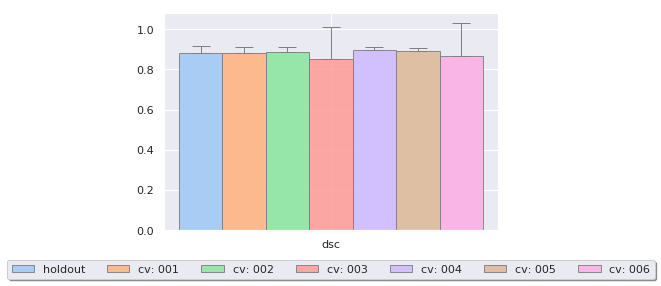

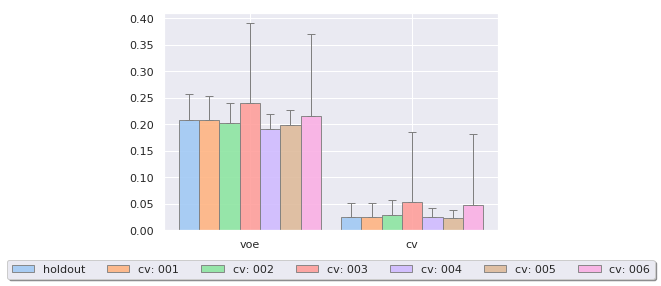

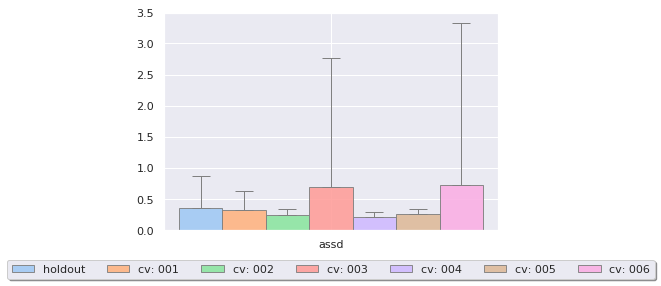

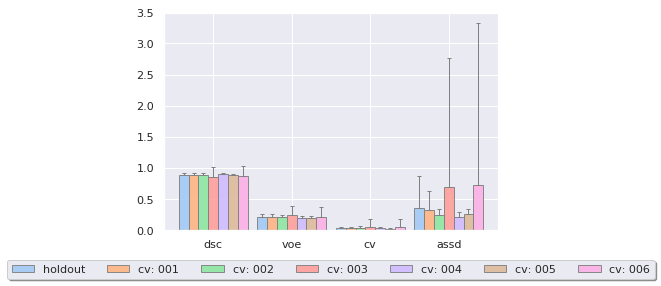

,holdout,cv: 001,cv: 002,cv: 003,cv: 004,cv: 005,cv: 006
dsc,$0.883\pm0.033$,$0.8835\pm0.029$,$0.8873\pm0.023$,$0.8498\pm0.161$,$0.8942\pm0.018$,$0.8901\pm0.018$,$0.8644\pm0.167$
voe,$0.208\pm0.05$,$0.2075\pm0.045$,$0.2018\pm0.038$,$0.2402\pm0.151$,$0.1909\pm0.029$,$0.1976\pm0.03$,$0.2161\pm0.155$
cv,$0.0244\pm0.027$,$0.025\pm0.026$,$0.0279\pm0.029$,$0.0521\pm0.132$,$0.025\pm0.016$,$0.0221\pm0.016$,$0.0471\pm0.135$
assd,$0.3544\pm0.518$,$0.3252\pm0.3$,$0.2436\pm0.093$,$0.6877\pm2.085$,$0.2128\pm0.069$,$0.2535\pm0.087$,$0.7306\pm2.6$


In [10]:
# plot results of each testing set in CV experiments
# naming convention: 'cv: 001' corresponds to cross-validation experiment 1
# assumes testing bins for each cross-validation experiment are disjoint

exps = {'holdout': holdout_metrics}
exps_keys = ['holdout']
# add cross validation experiments:
for i in range(1,7):
    cv_key = 'cv: %03d' % i
    exps[cv_key] = io_utils.load_pik(os.path.join(cv1_base_path % i, 'metrics.dat'))
    exps_keys.append(cv_key)

plot_metrics(['dsc'], exps_keys, exps)
plot_metrics(['voe', 'cv'], exps_keys, exps)
plot_metrics(['assd'], exps_keys, exps)
df = plot_metrics(['dsc', 'voe', 'cv', 'assd'], exps_keys, exps)
display(df)